In [129]:
import numpy as np
import pandas as pd

# Patient Segmentation using K-means

Here the focus is applying PCA and K-means for segmentation.
Showing some possible analysis for a clustering approach.

K-means algo:
- assign k centroids
- calculate distance of each object from each centroid
- assign each object to the closest centroid
- recalculate the position of the k centroids to minimize intra-cluster and maximize inter-cluster distance
- repeat until the centroids no longer change

K-means++  has better initialization of the centroids

Elbow Method:

It involves plotting the within-cluster sum of squares (WCSS) for different cluster numbers and identifying the “elbow” point where WCSS starts to level off

# Why Cluster PCA Results?
- Reduced Complexity: PCA reduces the dimensionality of the data, which often makes clustering more effective and interpretable.
- Uncovering Patterns: Clustering on PCA-transformed data can reveal patterns and groupings that might not be obvious in the high-dimensional original data.

Let's read the dataset

Our goal is to use K-means to find patterns between patients

In [130]:
df = pd.read_csv("/Users/simoneboesso/Desktop/PatientSegmentationCancer/leukemia_cancer_cell.tsv",sep="\t",on_bad_lines= "skip")

In [131]:
df.shape

(942, 68)

In [132]:
df.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Age At Specimen Acquisition', 'FLT3-ITD Allelic Ratio', 'ASXL1',
       'Cancer Type', 'Cancer Type Detailed', 'Cause Of Death',
       'CEBPA bi-allelic', 'Center ID', 'Cohort', 'Cumulative Chemo',
       'Unique Regiments', 'No. Of Cumulative Regiments',
       'Unique Treatment Stages', 'No. Of Unique Treatment Stages',
       'Unique Treatment Types', 'No. Of Cumulative Treatments',
       'Current Regimen', 'Current Stage',
       'Disease Stage At Specimen Collection', 'Diagnosis At Inclusion',
       'ELN2017', 'Ethnicity Category', 'FAB BLAST morphology', 'FLT3-ITD',
       'De Novo', 'Relapsed', 'Transformed', 'Karyotype',
       'Most Recent Treatment Duration', 'Most Recent Treatment Type',
       'Mutation Count', 'Diagnosis non AML, MDS, MPN', 'NPM1',
       'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status',
       'Other Cytogenetics', 'Prior Non-Myeloid', 'Prior Malignancy Rad

In [133]:
'''nan_counts = df.isna().sum()
for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")'''

'nan_counts = df.isna().sum()\nfor column, count in nan_counts.items():\n    print(f"Column \'{column}\': {count} NaN values")'

Let's remove the columns with too many Nans

In [134]:
df.drop(["RUNX1","Other Cytogenetics","Type Non-Myeloid","FAB BLAST morphology","Response To Induction","Race Category","Treatment Type Induction","Ethnicity Category","Surface Antigens Immunohistochemical Stains","Response Duration To Induction","ASXL1","TP53 Pathway", "CEBPA bi-allelic","Variant Summary"], axis = 1, inplace=True)

In [135]:
df_cleaned = df.dropna().copy()
df_cleaned.shape

(675, 54)

Let's extract the info about the patient id

In [136]:
ids = df_cleaned.iloc[:,:3]
ids.head()
df_cleaned.drop(["Study ID","Patient ID", "Sample ID"], axis = 1, inplace=True)

In [137]:
df_cleaned.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,65.0,65.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Treatment,2,Waves1+2,Yes,Decitabine,...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Bone Marrow Aspirate,0,0.900000,Yes
1,68.0,68.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,5,Waves1+2,Yes,AG-221|Azacitidine|Clofarabine,...,1,Male,MATCHED,False,AML with myelodysplasia-related changes,Post-Chemotherapy|Residual Disease,Bone Marrow Aspirate,34,1.033333,Yes
3,75.0,75.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,Hydroxyurea|Decitabine,...,1,Male,MATCHED,False,Therapy-related myeloid neoplasms,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Bone Marrow Aspirate,0,0.500000,Yes
4,52.0,53.0,0.0,Leukemia,Acute Leukemias of Ambiguous Lineage,Dead-Disease,1,Both,Yes,"7+3 (Cytarabine, Idarubicin)|Sunitinib|HAM (Cy...",...,1,Male,UNMATCHED,False,"Mixed phenotype acute leukaemia, T/myeloid, NOS",Post-Transplant|Post-Chemotherapy|Residual Dis...,Peripheral Blood,234,0.066667,No
6,53.0,53.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,"Fludarabine, Melphalan|7+3 (Cytarabine, Idarub...",...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Leukapheresis,0,1.200000,Yes


In [138]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}
        self.indexes = []

    def fit(self, X, y=None):
        for column in X.columns:
            if X[column].dtype == "object":
                le = LabelEncoder()
                le.fit(X[column])
                self.label_encoders[column] = le
                self.indexes.append(column)
        
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for column, le in self.label_encoders.items():
            X_encoded[column] = le.transform(X[column])
        return X_encoded
    


    def inverse_transform(self, X):
        X_decoded = X.copy()
        for column, le in self.label_encoders.items():
            encoded_labels = X_decoded[column]
            X_decoded [column] = le.inverse_transform(encoded_labels)
            
        return  X_decoded

Let's convert the objects types to string and then perform a label encoding!

In [139]:
''' This iterate on each column, convert to string and then perform the label encoding! 
'''
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoderTransformer()
encoder.fit(df_cleaned)
df_tra = encoder.transform(df_cleaned)
df_tra.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,65.0,65.0,0.0,0,1,3,2,1,1,252,...,1,1,0,False,5,0,0,0,0.900000,1
1,68.0,68.0,0.0,0,1,1,5,1,1,156,...,1,1,0,False,6,13,0,34,1.033333,1
3,75.0,75.0,0.0,0,1,1,1,1,1,353,...,1,1,0,False,25,1,0,0,0.500000,1
4,52.0,53.0,0.0,0,0,1,1,0,1,141,...,1,1,1,False,21,17,2,234,0.066667,0
6,53.0,53.0,0.0,0,1,1,1,1,1,290,...,1,1,0,False,5,0,1,0,1.200000,1


Let's normalize!

In [140]:
scaler = StandardScaler()
standardized_df = scaler.fit_transform(df_tra)
standardized_df = pd.DataFrame(standardized_df,columns=df_cleaned.columns)


# Principal Component Analysis

Let's first find the best number of components to use!

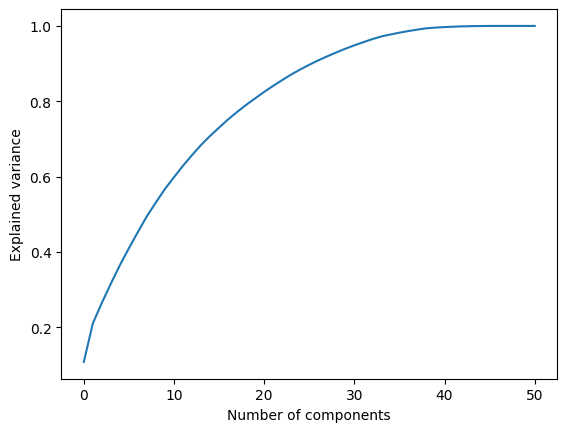

In [141]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(standardized_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()


Let's extract the dataset we'll use for the clustering after feature reduction

In [142]:
pca = PCA(n_components=0.8)
pca.fit(standardized_df)
reduce_df = pca.transform(standardized_df)
reduce_df = pd.DataFrame(reduce_df,columns=[f'Component{i}'for i in range(1,21)])
reduce_df.shape

(675, 20)

Clearly the dataset has less columns

# K-Means

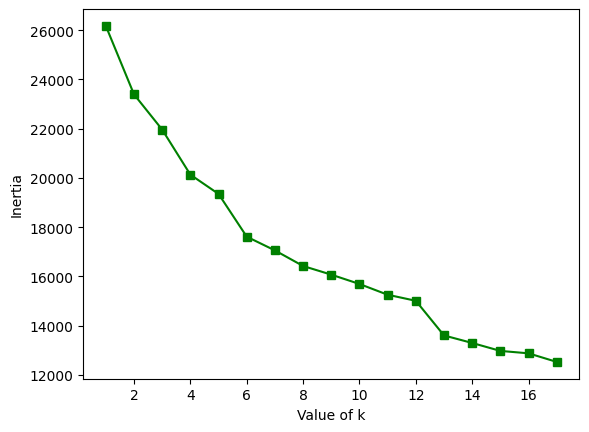

In [143]:
from sklearn.cluster import KMeans

inertia_scores = []
for i in range(1,18):
    model = KMeans(n_clusters=i, init = "k-means++",random_state=42)
    model.fit(reduce_df)
    inertia_scores.append(model.inertia_)

plt.plot(range(1,18),inertia_scores, 'gs-')
plt.xlabel("Value of k")
plt.ylabel("Inertia")
plt.show()

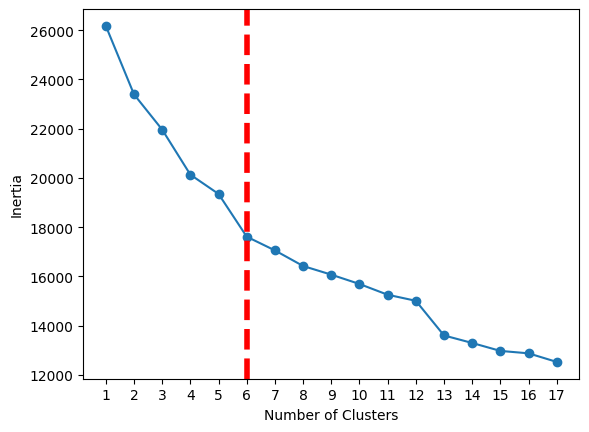

In [144]:
from kneed import KneeLocator
k1 = KneeLocator (range (1, 18), inertia_scores, curve = "convex", direction = "decreasing")
plt.plot (range (1,18), inertia_scores , marker = 'o')
plt.xticks (range (1, 18))
plt.xlabel ("Number of Clusters")
plt.ylabel ("Inertia")
plt.axvline (x = k1.elbow, color = "red", label = "axvline - full height",linewidth = 4, linestyle ="--")
plt.show()

In [145]:
model = KMeans(n_clusters=6, random_state=42).fit(reduce_df)
preds = model.predict(reduce_df)
centers = model.cluster_centers_

Now for visualization reasons, let's take the first and second components

Principal Component 1 (PC1): This axis captures the most variance in the data. Variations along this axis represent the most significant differences among the Patients.

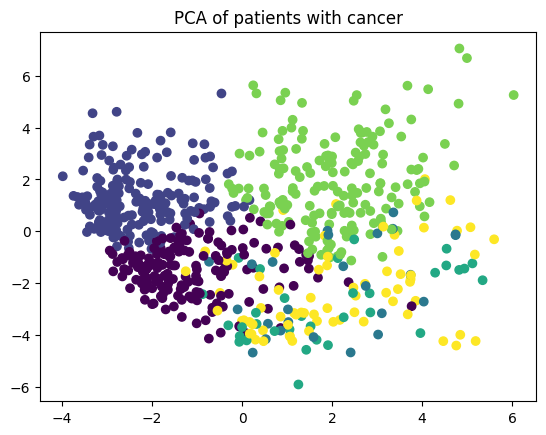

In [146]:
plt.scatter(reduce_df["Component1"],reduce_df["Component2"],c = preds)
plt.title("PCA of patients with cancer")
plt.show()

Let's try the same but in 3-D

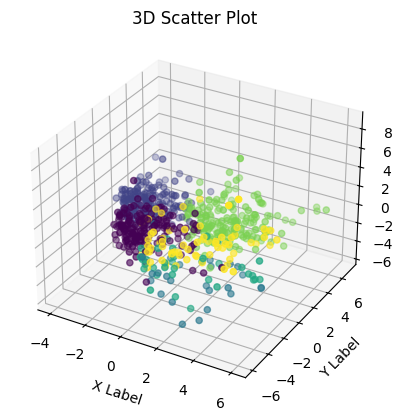

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduce_df["Component1"]
y = reduce_df["Component2"]
z = reduce_df["Component3"]

ax.scatter(x, y, z,c = preds)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

plt.show()

Let's combine now the PCA dataset with the scaled

In [148]:
combined_df = pd.concat([reduce_df, standardized_df], axis=1)
combined_df.head()

,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Component8,Component9,Component10,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,-1.645560,-2.037179,0.770115,-1.828658,-0.335993,0.291424,-0.718385,0.150951,-0.810652,-1.612482,...,-0.54326,0.886405,-0.824078,0.0,-0.557871,-0.661085,-0.805930,-0.302513,0.931756,0.504625
1,3.355544,-2.705670,2.173657,2.164320,-0.090696,-1.008254,-1.110164,0.975345,-1.382686,0.800064,...,-0.54326,0.886405,-0.824078,0.0,-0.404485,0.774812,-0.805930,-0.099089,1.215892,0.504625
2,0.576149,-2.994170,0.493527,-2.051835,1.447436,-0.181799,0.117820,0.369630,2.538914,0.341824,...,-0.54326,0.886405,-0.824078,0.0,2.509851,-0.550632,-0.805930,-0.302513,0.079348,0.504625
3,2.899312,3.653722,2.149217,1.777190,14.211093,7.381966,2.044548,-2.462377,-3.609694,0.543529,...,-0.54326,0.886405,1.213477,0.0,1.896307,1.216626,1.266461,1.097525,-0.844095,-1.981668
4,-1.753066,0.867685,2.014717,-0.411415,-1.610815,2.033385,-1.402216,0.588061,-0.196740,-0.666826,...,-0.54326,0.886405,-0.824078,0.0,-0.557871,-0.661085,0.230266,-0.302513,1.571062,0.504625


Let's add another layer to our analysis, analysing the loadings.

The loadings are coefficients that describe how each principal component is a combination of the original features.

In [149]:
# Get the PCA components (loadings)
pca_components_loads = pca.components_

# Create a DataFrame for better visualization and analysis
pca_loadings_df = pd.DataFrame(pca_components_loads, columns=standardized_df.columns,index=[f'PC{i}' for i in range(1,21)])

# Display the loadings
pca_loadings_df.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
PC1,0.115935,0.127735,0.083604,5.551115e-17,0.010364,0.154047,0.031968,-0.073586,-0.054302,0.065389,...,0.205166,0.052044,0.085007,-0.000000e+00,0.054841,0.306479,0.084369,0.178802,0.050063,-0.223869
PC2,-0.301896,-0.292274,0.089665,0.000000e+00,-0.049300,-0.090879,-0.113297,-0.008946,0.128772,-0.020857,...,0.143027,-0.098213,0.141121,0.000000e+00,-0.012568,0.127432,0.020107,0.171448,-0.128179,-0.142569
PC3,0.008972,0.009895,-0.098642,1.040834e-16,-0.092683,0.031147,-0.015818,-0.191085,0.115571,-0.072543,...,0.005407,0.061641,-0.361894,9.403955e-38,0.125499,0.057553,-0.106312,-0.005948,0.467740,0.006187
PC4,-0.134617,-0.134853,-0.204941,-1.110223e-16,-0.089515,-0.041556,0.060105,0.118649,0.150350,0.088813,...,-0.102360,0.044055,0.114386,3.291384e-37,0.053551,-0.031728,0.013445,0.002496,-0.128114,0.053851
PC5,0.033372,0.034283,-0.029974,3.330669e-16,-0.489051,0.007938,0.003751,0.074670,-0.046395,-0.054750,...,-0.089676,0.017574,0.130073,3.009266e-36,0.188533,0.014239,0.099451,-0.017006,-0.157114,0.035824


In [156]:
absolute_loadings = np.abs(pca_components_loads)
top_5_indices = np.argsort(absolute_loadings, axis=1)[:, -5:]
top_5_columns = np.array(standardized_df.columns)[top_5_indices]
top_5_columns_df = pd.DataFrame(top_5_columns, columns=[f'Top {i+1}' for i in range(5)], index=[f'PC{i}' for i in range(1, 21)])
top_5_columns_df.head()

,Top 1,Top 2,Top 3,Top 4,Top 5
PC1,Used In Manuscript,ELN2017,Specimen Groups,Disease Stage At Specimen Collection,De Novo
PC2,No. Of Cumulative Treatments,Age At Specimen Acquisition,No. Of Cumulative Regiments,Age at Diagnosis,No. Of Unique Treatment Stages
PC3,Prior MDS/MPN >Two Months,Prior MDS/MPN,Somatic Status,Mutation Count,TMB (nonsynonymous)
PC4,NPM1,Most Recent Treatment Type,Transformed,Prior MDS > Two Months,Prior MDS
PC5,Prior MPN,Prior MPN > Two Months,Diagnosis At Inclusion,Oncotree Code,Cancer Type Detailed


These are the weights, basically if i have high loads for feature A it means the PC_k is highly influnced by A

Key insigths:
- PC1 is heavily influenced by used in manuscript, and the ELN2017 risk stratification, also by the specimen group, and Disease Stage At Specimen Collection. It likely represent a general profile of the patient, capturing the risk of the patient.
- PC2 captures aspects of the number of past treatments and the age of the diagnosis, still factors that could be determinant to know the prognosis of the patients

Let's add another layer: 
# Interpreting the Cluster Centers

After applying KMeans clustering to the PCA-transformed data, you end up with cluster centers in the PCA space.

These centers are valuable as they represent the “average” member of each cluster in the transformed space, we need to transform back!

In [151]:
original_space_centroids = scaler.inverse_transform(pca.inverse_transform(centers))
centroids_df = pd.DataFrame(original_space_centroids, columns=standardized_df.columns)
indexes = encoder.indexes
for index in indexes:
    centroids_df[index] = np.round(centroids_df[index]).astype(int)   ## There is a way better than this?


Key insights:
- Seems like the average behaviour is a lot influenced by the Specific Diagnosis At Inclusion. 
- here if we had the column description we can extract the profile of each cluster;

Therefore, basically which is the diagnosis when they were included in the dataset;


In [157]:
Original_centroids_df = encoder.inverse_transform(centroids_df)
Original_centroids_df.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,66.231800,66.236099,0.037113,Leukemia,Acute Myeloid Leukemia,Dead-Disease,2.562371,Waves1+2,Yes,AG-120|KB004|Lenalidomide|Venetoclax (ABT-199)...,...,1.158407,Male,MATCHED,-3.843352e-21,AML with t(9;11)(p22;q23); MLLT3-MLL,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Leukapheresis,-4.786184,0.473071,Yes
1,43.767722,43.919571,0.260580,Leukemia,Acute Myeloid Leukemia,Alive,1.902829,Waves1+2,Yes,Azacitidine|Momelotinib,...,1.166827,Female,MATCHED,1.287350e-20,AML with t(8;21)(q22;q22); RUNX1-RUNX1T1,Initial Acute Leukemia Diagnosis,Leukapheresis,2.514854,0.397101,Yes
2,67.631419,67.762467,0.162222,Leukemia,Acute Myeloid Leukemia,Dead-Disease,2.491440,Waves1+2,Yes,"Cytarabine|3+7 (Cytarabine, Daunorubicin)",...,1.631918,Male,UNMATCHED,6.822443e-20,AML with t(6;9)(p23;q34); DEK-NUP214,Post-Chemotherapy|Post-Transplant,Leukapheresis,12.673133,0.430093,Yes
3,68.449214,68.693134,0.687224,Leukemia,Acute Myeloid Leukemia,Dead-Other,2.857472,Waves1+2,Yes,"Crenolanib|MEC, plexifor, GCSF|Sorafenib|7+3 (...",...,1.345599,Male,MATCHED,-7.174481e-20,AML with t(9;11)(p22;q23); MLLT3-MLL,Post-Chemotherapy|Post-DLI|Post-Transplant|Res...,Leukapheresis,42.713055,0.521627,Yes
4,53.602783,54.914778,1.192379,Leukemia,Acute Myeloid Leukemia,Dead-Disease,2.250706,Waves1+2,Yes,"Azacitidine, Lenalidomide",...,1.897257,Male,UNMATCHED,-6.405776e-21,AML with t(9;11)(p22;q23); MLLT3-MLL,Post-Transplant|Post-Chemotherapy,Leukapheresis,167.102109,0.450022,No


# Comparative analysis
- Compare these cluster centers with the overall mean of the original data to see how each cluster differs from the average.
- The actions that we can take are: 
    - if for example cluster 2 and 3 have significantly lower Feature A (eg.FLT3-ITD Allelic Ratio ) it means there is there a a difference worth to inspect. 
    - Now, which actions can be taken? Well for example create a strategy to learn more about it, or creating a product  targetting that feature since it means there is a particular need there.
    - Take also in consideration the number of instances in each cluster, maybe an important info about an opportunity to fill a market gap;

In [154]:
df_cleaned.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,65.0,65.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Treatment,2,Waves1+2,Yes,Decitabine,...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Bone Marrow Aspirate,0,0.900000,Yes
1,68.0,68.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,5,Waves1+2,Yes,AG-221|Azacitidine|Clofarabine,...,1,Male,MATCHED,False,AML with myelodysplasia-related changes,Post-Chemotherapy|Residual Disease,Bone Marrow Aspirate,34,1.033333,Yes
3,75.0,75.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,Hydroxyurea|Decitabine,...,1,Male,MATCHED,False,Therapy-related myeloid neoplasms,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Bone Marrow Aspirate,0,0.500000,Yes
4,52.0,53.0,0.0,Leukemia,Acute Leukemias of Ambiguous Lineage,Dead-Disease,1,Both,Yes,"7+3 (Cytarabine, Idarubicin)|Sunitinib|HAM (Cy...",...,1,Male,UNMATCHED,False,"Mixed phenotype acute leukaemia, T/myeloid, NOS",Post-Transplant|Post-Chemotherapy|Residual Dis...,Peripheral Blood,234,0.066667,No
6,53.0,53.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,"Fludarabine, Melphalan|7+3 (Cytarabine, Idarub...",...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Leukapheresis,0,1.200000,Yes


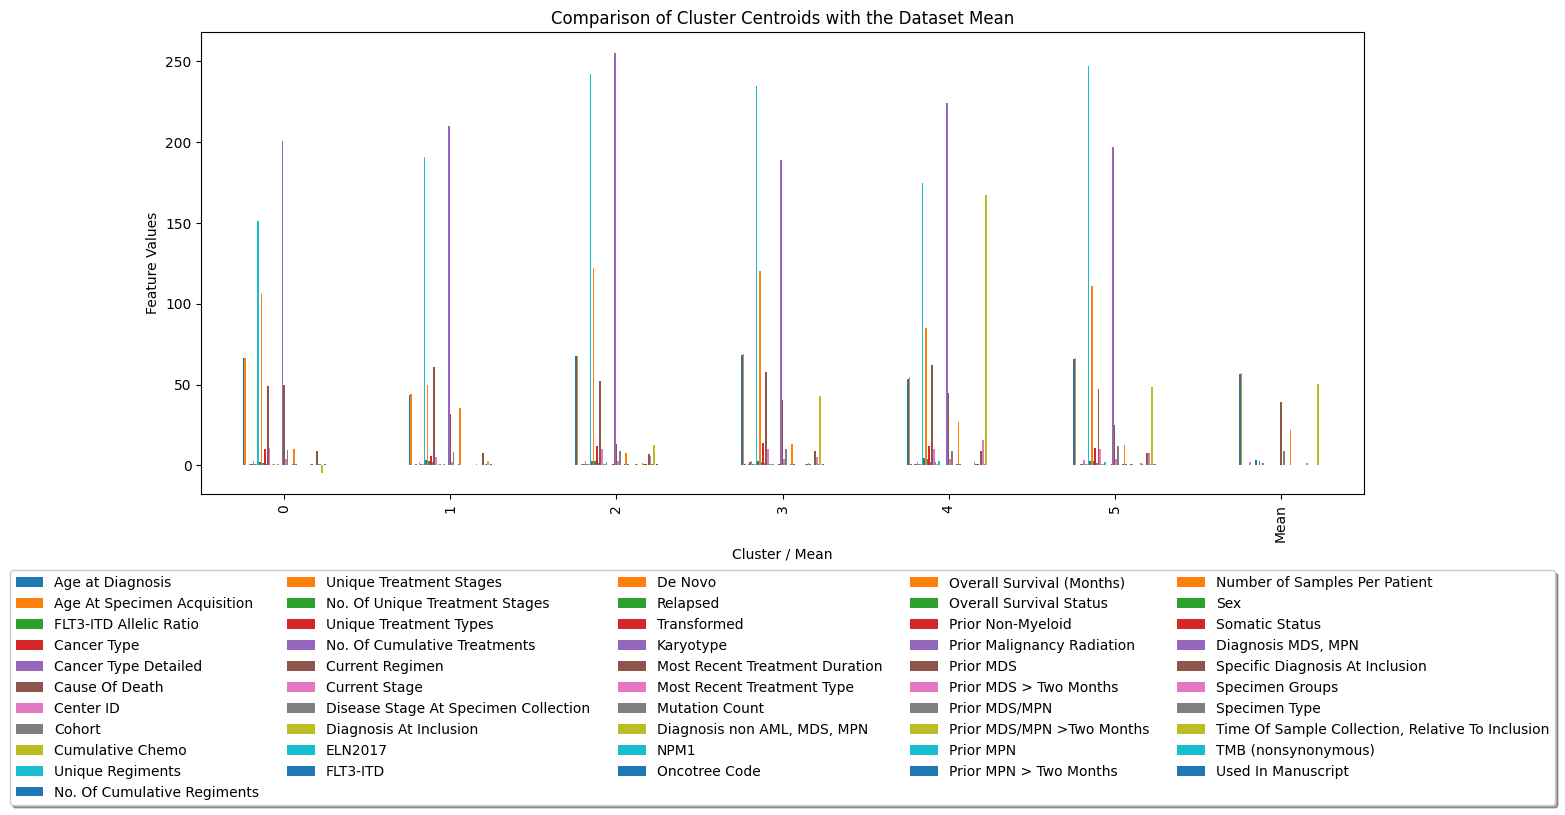

In [160]:
# Calculate the mean of the original data
original_means = df_cleaned.mean(axis=0,numeric_only=True)

numeric_columns = centroids_df.select_dtypes(include=['number'])
centroids_comparison_df = centroids_df[numeric_columns.columns].copy()


centroids_comparison_df.loc['Mean'] = original_means

# Visualization
import matplotlib.pyplot as plt

# Visualizing the comparison
centroids_comparison_df.plot(kind='bar', figsize=(15, 6))
plt.title('Comparison of Cluster Centroids with the Dataset Mean')
plt.xlabel('Cluster / Mean')
plt.ylabel('Feature Values')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
plt.show()

- Here for each cluster extract the focus that each cluster has comparing with the mean beaviour. 
- sometimes we see behaviour that are very similar to the mean behaviour! 
- If we want to target a specific segment for example discovering which are their needs  differently from the average user

# Recap:
- Analysing the loadings we can extract which features were more important for that component (and if most relevant are related they can be used for describing a pattern)
- Extracting the centroid, is used to see which is the average behavior, and comparing with the mean behaviour we can see how a given segment(cluster) differentiate from the "normal" behaviour;